<a href="https://colab.research.google.com/github/GrE3lzzz/Gittea/blob/main/Classically_Punk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tarfile
import urllib.request
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [ ]:
# URL of dataset
data_url = "https://storage.googleapis.com/qwasar-public/track-ds/classically_punk_music_genres.tar.gz"
data_path = "classically_punk_music_genres.tar.gz"
dataset_folder = "classically_punk_music_genres"

In [ ]:
# Step 1: Download & Extract Dataset
if not os.path.exists(dataset_folder):
    print("Downloading dataset...")
    urllib.request.urlretrieve(data_url, data_path)
    print("Extracting dataset...")
    with tarfile.open(data_path, "r:gz") as tar:
        tar.extractall(path=dataset_folder)
    print("Extraction completed.")

# Verify dataset extraction
if not os.path.exists(dataset_folder) or len(os.listdir(dataset_folder)) == 0:
    raise ValueError("Dataset extraction failed or folder is empty.")

Extracting dataset...
Extraction completed.


In [ ]:
# Step 2: Feature Extraction Function
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        return np.mean(mfcc, axis=1)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [ ]:
# Step 3: Read Files & Extract Features
audio_files = []
labels = []

genres_path = os.path.join(dataset_folder, "genres")
if not os.path.exists(genres_path) or not os.path.isdir(genres_path):
    raise ValueError(f"Genres directory not found at: {genres_path}")

for genre in os.listdir(genres_path):
    genre_path = os.path.join(genres_path, genre)
    if os.path.isdir(genre_path):
        print(f"Processing genre: {genre}")
        files = [f for f in os.listdir(genre_path) if f.endswith(".wav")]
        if len(files) == 0:
            print(f"No .wav files found in genre: {genre}")
            continue
        for file in files:
            file_path = os.path.join(genre_path, file)
            print(f"Processing file: {file_path}")
            features = extract_features(file_path)
            if features is not None:
                audio_files.append(features)
                labels.append(genre)
            else:
                print(f"Failed to extract features for file: {file_path}")
    else:
        print(f"Skipping non-directory: {genre}")

# Ensure files were processed successfully
if len(audio_files) == 0 or len(labels) == 0:
    raise ValueError("No valid audio files or labels found. Check dataset and feature extraction.")

Skipping non-directory: po.mf
Processing genre: rock
Processing file: classically_punk_music_genres/genres/rock/rock.00044.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00045.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00013.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00035.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00024.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00094.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00046.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00070.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00059.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00020.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00028.wav
Processing file: classically_punk_music_genres/genres/rock/rock.00042.wav
Processing file: classically_punk_music_genres/genres/rock/

In [ ]:
# Step 4: Convert to DataFrame & Encode Labels
data = pd.DataFrame(audio_files)
if data.empty:
    raise ValueError("No valid audio features extracted. Check dataset and feature extraction.")

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(labels)

# Normalize Features
X = data.drop(columns=['label'])
y = data['label']
X = (X - X.mean()) / X.std()

# Ensure X and y are not empty
if X.empty or y.empty:
    raise ValueError("Feature matrix X or labels y are empty. Cannot proceed with training.")

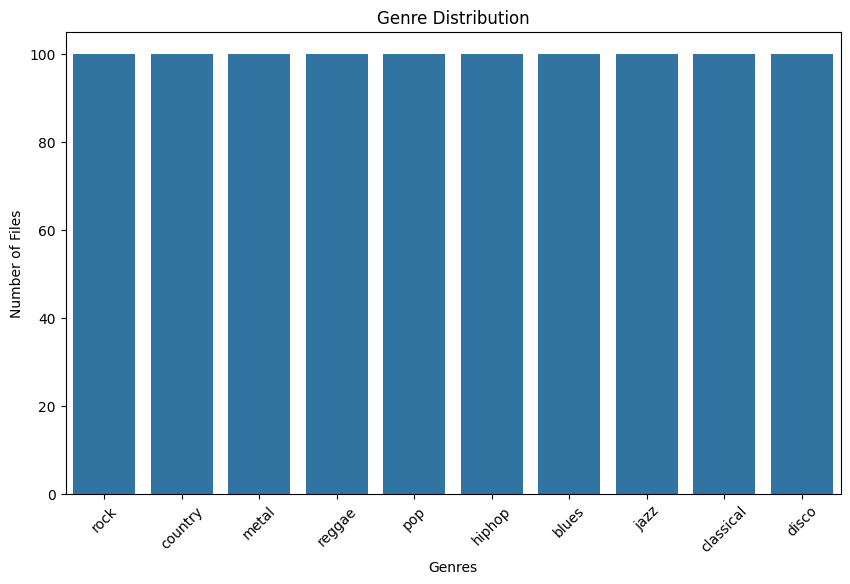

In [ ]:
# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Exploration: Genre Distribution
genre_counts = {genre: len(os.listdir(os.path.join(genres_path, genre))) for genre in os.listdir(genres_path) if os.path.isdir(os.path.join(genres_path, genre))}
plt.figure(figsize=(10, 6))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.title("Genre Distribution")
plt.xlabel("Genres")
plt.ylabel("Number of Files")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Step 6: Build Deep Learning Model
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Step 7: Train Model with Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.0938 - loss: 2.4344

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1508 - loss: 2.2772 - val_accuracy: 0.3750 - val_loss: 1.8688
Epoch 2/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2812 - loss: 1.7832

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3645 - loss: 1.7917 - val_accuracy: 0.4400 - val_loss: 1.6096
Epoch 3/50
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4225 - loss: 1.6129 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4256 - loss: 1.6067 - val_accuracy: 0.4800 - val_loss: 1.4233
Epoch 4/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5034 - loss: 1.4346 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5043 - loss: 1.4307 - val_accuracy: 0.5400 - val_loss: 1.3293
Epoch 5/50
14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5634 - loss: 1.2424 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5579 - loss: 1.2607 - val_accuracy: 0.5450 - val_loss: 1.2470
Epoch 6/50
15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5704 - loss: 1.1961 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5699 - loss: 1.2047 - val_accuracy: 0.5650 - val_loss: 1.2150
Epoch 7/50
11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6058 - loss: 1.1335 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6088 - loss: 1.1361 - val_accuracy: 0.5750 - val_loss: 1.1424
Epoch 8/50
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6079 - loss: 1.1036

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6117 - loss: 1.0997 - val_accuracy: 0.5800 - val_loss: 1.0873
Epoch 9/50
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6492 - loss: 0.9653 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6508 - loss: 0.9706 - val_accuracy: 0.6100 - val_loss: 1.0740
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6928 - loss: 0.9200 - val_accuracy: 0.6050 - val_loss: 1.0762
Epoch 11/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7188 - loss: 0.9200

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6881 - loss: 0.9203 - val_accuracy: 0.6250 - val_loss: 1.0215
Epoch 12/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.5938 - loss: 1.2892

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7042 - loss: 0.8970 - val_accuracy: 0.6350 - val_loss: 1.0041
Epoch 13/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8125 - loss: 0.5294

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7186 - loss: 0.8105 - val_accuracy: 0.6600 - val_loss: 0.9807
Epoch 14/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8125 - loss: 0.7492

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7579 - loss: 0.7428 - val_accuracy: 0.6500 - val_loss: 0.9696
Epoch 15/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.7188 - loss: 0.7535

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7226 - loss: 0.7545 - val_accuracy: 0.6750 - val_loss: 0.9539
Epoch 16/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7812 - loss: 0.5852

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7808 - loss: 0.6900 - val_accuracy: 0.6600 - val_loss: 0.9503
Epoch 17/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.8750 - loss: 0.6586

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7783 - loss: 0.6702 - val_accuracy: 0.6800 - val_loss: 0.9300
Epoch 18/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7533 - loss: 0.6665 - val_accuracy: 0.6450 - val_loss: 0.9614
Epoch 19/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7674 - loss: 0.6553 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7675 - loss: 0.6557 - val_accuracy: 0.6750 - val_loss: 0.9280
Epoch 20/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.7812 - loss: 0.6375

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8096 - loss: 0.5796 - val_accuracy: 0.6850 - val_loss: 0.9208
Epoch 21/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8058 - loss: 0.6059 - val_accuracy: 0.6600 - val_loss: 0.9467
Epoch 22/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7812 - loss: 0.5232

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8131 - loss: 0.5415 - val_accuracy: 0.6950 - val_loss: 0.9123
Epoch 23/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8421 - loss: 0.5035 - val_accuracy: 0.7050 - val_loss: 0.9153
Epoch 24/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8438 - loss: 0.4996

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8472 - loss: 0.5007 - val_accuracy: 0.7150 - val_loss: 0.9033
Epoch 25/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8092 - loss: 0.5147 - val_accuracy: 0.6800 - val_loss: 0.9127
Epoch 26/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8583 - loss: 0.4420 - val_accuracy: 0.7050 - val_loss: 0.9157
Epoch 27/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8532 - loss: 0.4525 - val_accuracy: 0.6850 - val_loss: 0.9054
Epoch 28/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8596 - loss: 0.4349 - val_accuracy: 0.7000 - val_loss: 0.9240
Epoch 29/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8703 - loss: 0.3798 - val_accuracy: 0.6850 - val_loss: 0.9247
Epoch 30/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8737 - loss: 0.4212 - val_accuracy: 0.6900 - val_loss: 0.9277
Epoch 31/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8656 - loss: 0.4082 - val_accuracy: 0.6900 - val_loss: 0.9

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6748 - loss: 1.0344
Test Accuracy: 0.7149999737739563
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


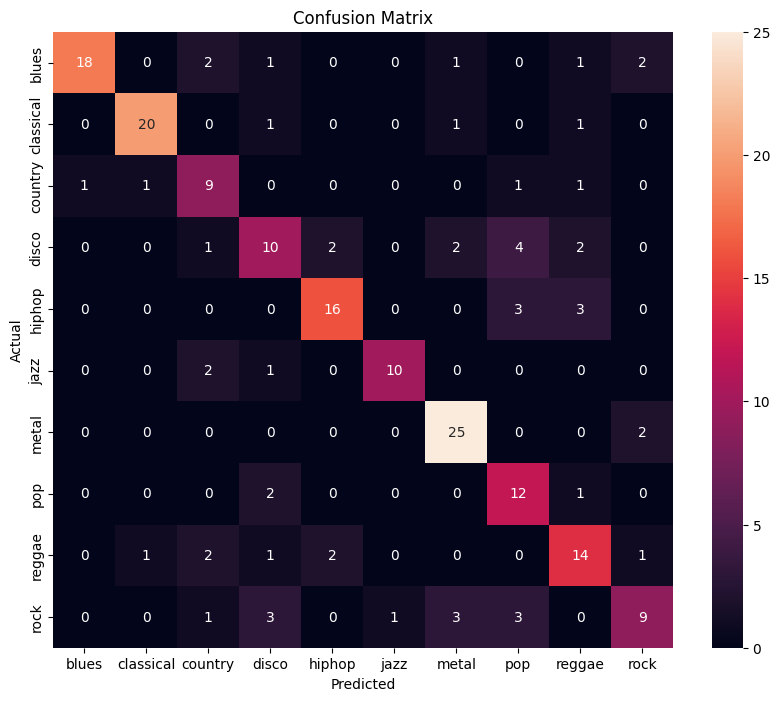

In [ ]:
# Step 8: Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Data Visualization: Confusion Matrix
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Step 9: Save Label Encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [ ]:
# Step 10: Classification Report
print("\n--- Final Report ---")
print(f"Total Genres: {len(label_encoder.classes_)}")
print(f"Total Training Samples: {X_train.shape[0]}")
print(f"Total Test Samples: {X_test.shape[0]}")
print(f"Test Accuracy: {test_acc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


--- Final Report ---
Total Genres: 10
Total Training Samples: 800
Total Test Samples: 200
Test Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

       blues       0.95      0.72      0.82        25
   classical       0.91      0.87      0.89        23
     country       0.53      0.69      0.60        13
       disco       0.53      0.48      0.50        21
      hiphop       0.80      0.73      0.76        22
        jazz       0.91      0.77      0.83        13
       metal       0.78      0.93      0.85        27
         pop       0.52      0.80      0.63        15
      reggae       0.61      0.67      0.64        21
        rock       0.64      0.45      0.53        20

    accuracy                           0.71       200
   macro avg       0.72      0.71      0.70       200
weighted avg       0.73      0.71      0.72       200



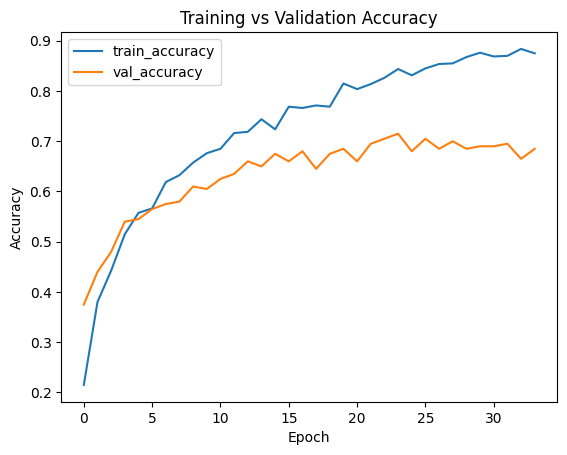

In [ ]:
# Step 11: Plot Training History
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()